# Model to Predict Next Day Energy Debt

The advantage of a solar-battery system is that if it is known that the next day is going to be cloudy you can charge the batteries up using cheap electricity at night and then use it during the day when electricity is more expensive. If successful, this will reduce the ROI of the system and reduce the monthly electricity bill. A model is being developed that can look at historical data for solar power production and weather reports to then use the forecast to decide on the level of battery charging for the next day.

The solar data has be scrapped from domestic solar installation owned by the author. A custom scrapper was created which pulled the daily energy data which has a resolution of 2 minutes and condensed the data into a single csv. 

The historic weather data was purchased from openweatherdata.com for a location close to the solar installation

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [2]:
# Import solar data

solar_data = pd.read_csv('solar_data_clean.csv', index_col=0)

# Inspect data

solar_data.head()

,Time,ePv1Day,ePv2Day,eToUserDay,eToGridDay,eInvDay,eRecDay
0,2019-03-02 00:00:16,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-03-02 00:02:15,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-03-02 00:04:18,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-03-02 00:06:17,0.0,0.0,0.1,0.0,0.0,0.0
4,2019-03-02 00:08:16,0.0,0.0,0.1,0.0,0.0,0.0


In [3]:
# Set Time coloumn to date time format and view data types

solar_data['Time'] =  pd.to_datetime(solar_data['Time'], format="%Y-%m-%d %H:%M:%S")
solar_data.dtypes

Time          datetime64[ns]
ePv1Day              float64
ePv2Day              float64
eToUserDay           float64
eToGridDay           float64
eInvDay              float64
eRecDay              float64
dtype: object

In [4]:
# Import historic weather data

weather_data = pd.read_csv('weather_data_clean.csv', index_col=0)

# Inspect data 

# weather_data.head()

In [5]:
# Set Time coloumn to date time format and view data types
weather_data['Time'] = pd.to_datetime(weather_data['dt_iso'], format="%Y-%m-%d %H:%M:%S")

# Drop other datetime coloumns 
weather_data = weather_data.drop(['dt','dt_iso'], axis=1)

# weather_data.dtypes

## Join solar data with weather data

Ideally this would be done using a join however the weather data has exact values for each hour whereas the solar data is more noisy 

Therefore the following method was implemented:

1. Subtract weather time from every solar_data time
2. Find the index where the time delta of the two times is a minimum
3. Join using data of the minimum time delta 
4. Apply recursively for everytime in weather data

This method is computationally intensive but it would only need to be performed once but has been shown here for demonstration.

In [6]:
weather_data = pd.merge_asof(weather_data, solar_data.sort_values('Time'), left_on='Time', right_on='Time', direction='nearest', tolerance=pd.Timedelta("600s"))

weather_data = weather_data.dropna(subset=['ePv1Day'])

weather_data = weather_data.drop(['sea_level','grnd_level', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h'],axis=1)

weather_data['Solar Energy'] = weather_data['ePv1Day'] + weather_data['ePv2Day'] 

weather_data.isnull().sum()

timezone               0
temp                   0
feels_like             0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
Time                   0
ePv1Day                0
ePv2Day                0
eToUserDay             0
eToGridDay             0
eInvDay                0
eRecDay                0
Solar Energy           0
dtype: int64

## Summary of merged data

## Find average/max weather for each day and then collect total solar data for each day

In [7]:
weather_data['date'] = weather_data['Time'].dt.date

day_df = weather_data.groupby('date').agg(
    temp_mean = ('temp','mean'), 
    temp_max = ('temp_max','max'), 
    temp_min = ('temp_min','min'), 
    pressure_mean = ('pressure','mean'),
    pressure_min = ('pressure','min'),
    pressure_max = ('pressure','max'),
    humidity_mean = ('humidity', 'mean'),
    humidity_min = ('humidity', 'min'),
    humidity_max = ('humidity', 'max'),
    wind_speed_mean = ('wind_speed', 'mean'),
    wind_speed_min = ('wind_speed', 'min'),
    wind_speed_max = ('wind_speed', 'max'),
    wind_deg_mean = ('wind_deg', 'mean'),
    wind_deg_min = ('wind_deg', 'min'),
    wind_deg_max = ('wind_deg', 'max'),
    clouds_all_mean = ('clouds_all', 'mean'),
    clouds_all_min = ('clouds_all', 'min'),
    clouds_all_max = ('clouds_all', 'max'),
    weather_id_mode = ('weather_id', lambda x: x.value_counts().index[0]),
    total_solar = ('Solar Energy','max')
    ).reset_index()

day_df.date = pd.to_datetime(day_df['date'], format="%Y-%m-%d")

In [8]:
# Estimate Sine fit for data with respect to day in year

day_df['date'] = pd.to_datetime(day_df['date'])
day_df['Day_count'] = day_df['date'].apply(lambda x: (x.to_pydatetime().date() - pd.Timestamp('2018-12-21').to_pydatetime().date()))
day_df['Day_count'] = day_df['Day_count'].dt.days
solar_mean = day_df['total_solar'].mean()
solar_std = (day_df['total_solar']).std()

print(solar_mean)
print(solar_std)

day_df['solar_sin'] = day_df['Day_count'].apply(lambda x: ((1.5*solar_std)*(math.sin((2*math.pi*(x-(365/4))/365))) + solar_mean))

11.912213740458002
7.2934542459888805


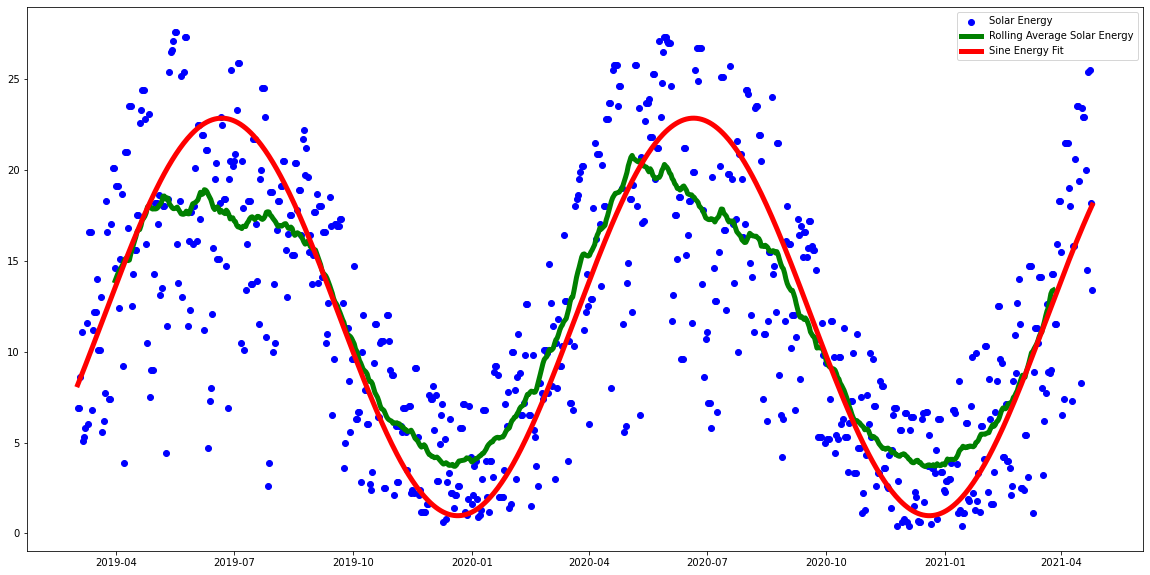

In [9]:
window_size = 60

day_df['rolling_solar'] = day_df['total_solar'].rolling(window=window_size).mean()

plt.figure(figsize=(20,10))

solar_energy_plt = plt.scatter(day_df['date'],day_df['total_solar'], marker='o',color = 'blue', label = 'Solar Energy')
average_energy_plt = plt.plot(day_df['date'],day_df['rolling_solar'].shift(int(-0.5*window_size)), color='green', linewidth=5.0)
sine_energy_plt = plt.plot(day_df['date'],day_df['solar_sin'], color='red', linewidth=5.0)

plt.legend((solar_energy_plt, average_energy_plt[0], sine_energy_plt[0]),('Solar Energy', 'Rolling Average Solar Energy', 'Sine Energy Fit'))

(-5.0, 35.0)

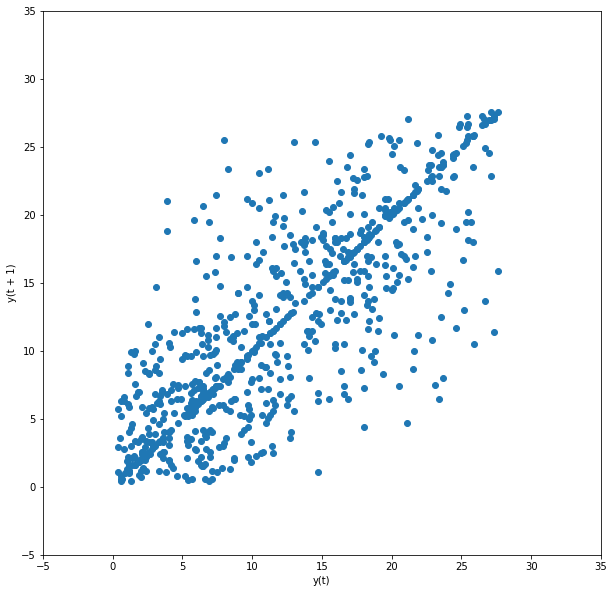

In [10]:
from pandas.plotting import lag_plot

plt.figure(figsize=(10,10))
lag_plot(day_df['total_solar'])
plt.xlim(left=-5, right=35)
plt.ylim(bottom=-5,top = 35)

In [11]:
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series
# data can said to have stationarity
#
from statsmodels.tsa.stattools import adfuller
#
# Run the test
#
df_stationarityTest = adfuller(day_df['total_solar'], autolag='AIC')
#
# Check the value of p-value
#
print("P-value: ", df_stationarityTest[1])

P-value:  0.29815083234483203


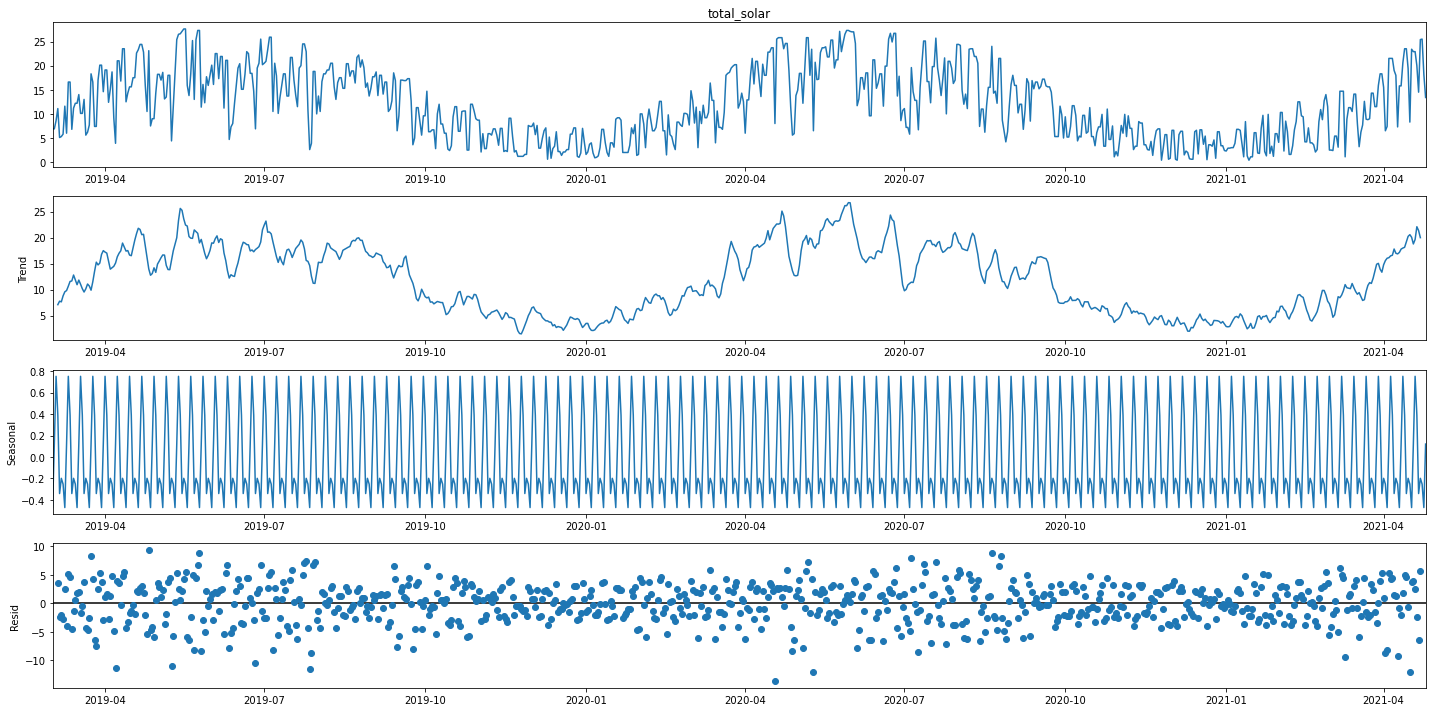

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

tdi = pd.DatetimeIndex(day_df.date)

day_df.set_index(tdi,inplace=True)

day_df.index.name='datetimeindex'

decomposed = seasonal_decompose(day_df['total_solar'], model='additive')

plt.rcParams["figure.figsize"] = (20,10)
decomposed.plot();

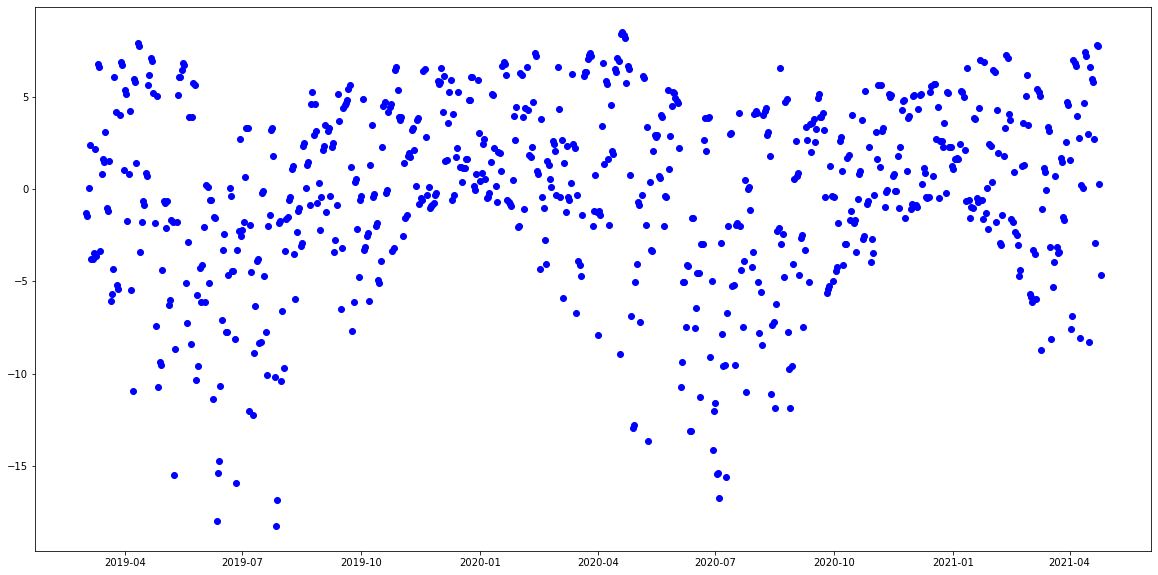

In [14]:
# Remove Trend from data by subtracting estimated sine wave in data

day_df['solar_minus_sine'] = day_df['total_solar'] - day_df['solar_sin']

plt.figure(figsize=(20,10))
solar_energy_plt = plt.scatter(day_df['date'],day_df['solar_minus_sine'], marker='o',color = 'blue', label = 'Solar Minus Sine')

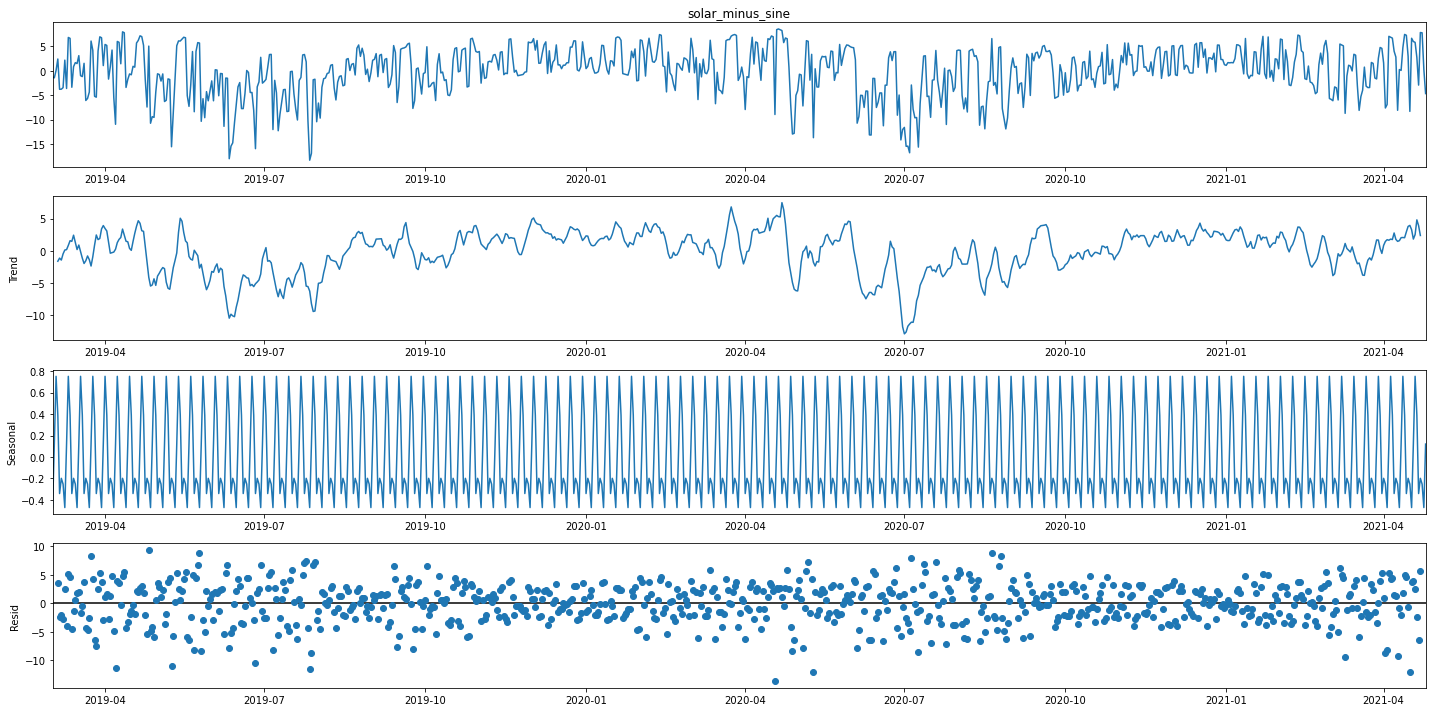

In [15]:
# Re-evalutate decomposition plot for data

decomposed = seasonal_decompose(day_df['solar_minus_sine'], model='additive')

plt.rcParams["figure.figsize"] = (20,10)
decomposed.plot();

In [16]:
# Run the test
#
df_stationarityTest = adfuller(day_df['solar_minus_sine'], autolag='AIC')
#
# Check the value of p-value
#
print("P-value: ", df_stationarityTest[1])

P-value:  0.00042630800984115873


The P-value for the data is now below the 5% threshold which suggests that the data now has a level of stationarity which is acceptable to apply an auto-correlation method

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

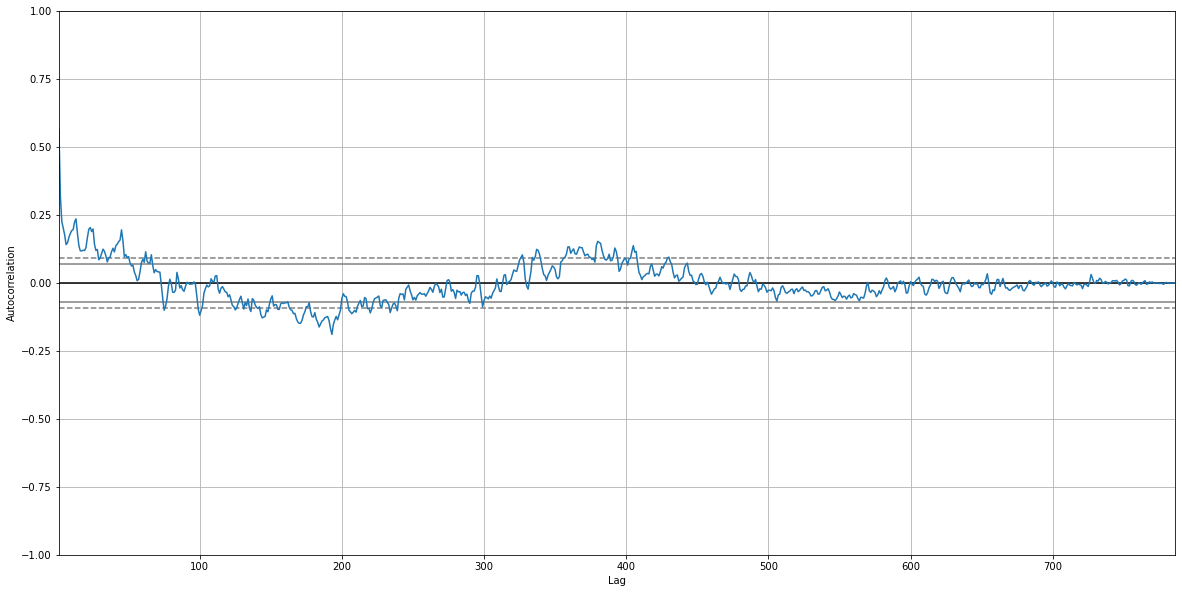

In [17]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(20,10))
autocorrelation_plot(day_df['solar_minus_sine'])

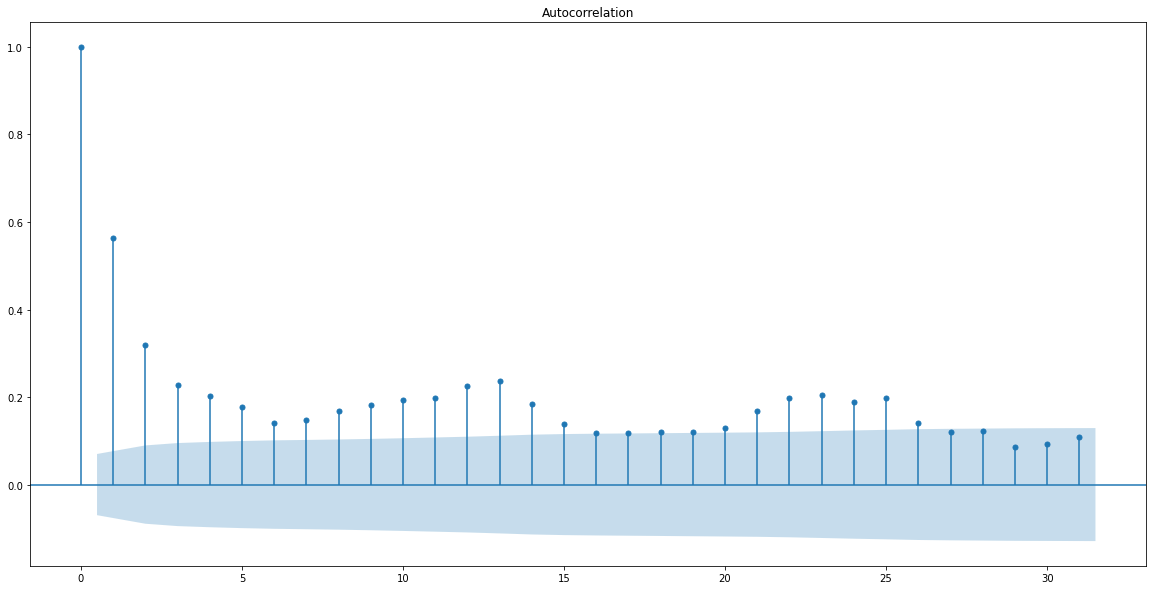

In [18]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(1,1,figsize=(20,10))
plot_acf(day_df['solar_minus_sine'], ax=ax, lags=31);


In [19]:
from statsmodels.tsa.ar_model import AR

#
# Create training and test data
#
train_data = day_df['solar_minus_sine'][:len(day_df)-int(len(day_df)*0.1)]
test_data = day_df['solar_minus_sine'][len(day_df)-int(len(day_df)*0.1):]
#
# Instantiate and fit the AR model with training data
#
ar_model = AR(train_data).fit()
#
# Print Summary
#
print(ar_model.summary())

                               AR Model Results                               
Dep. Variable:                      s  -                  o                  l
Model:                         AR(20)   Log Likelihood               -1927.983
Method:                          cmle   S.D. of innovations              3.988
Date:                Sun, 07 Nov 2021   AIC                              2.831
Time:                        18:16:39   BIC                              2.976
Sample:                    03-02-2019   HQIC                             2.887
                         - 02-06-2021                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0229      0.155     -0.148      0.883      -0.326       0.281
L1.solar_minus_sine      0.5370      0.039     13.900      0.000       0.461       0.613
L2.solar_min

C:\Users\chris\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)
C:\

<AxesSubplot:>

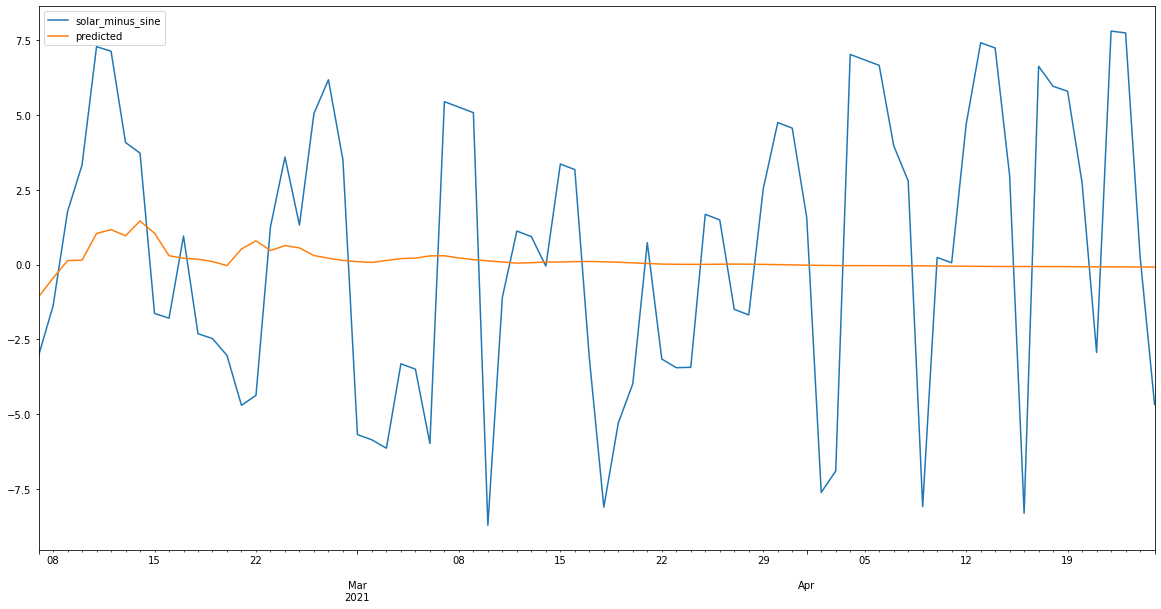

In [20]:
# make predictions 
predictions = ar_model.predict(
    start=len(train_data), 
    end=len(train_data) + len(test_data)-1, 
    dynamic=False)

# create a comparison dataframe
compare_df = pd.concat(
    [day_df['solar_minus_sine'].tail(int(len(day_df)*0.1)),
    predictions], axis=1).rename(
    columns={'stationary': 'actual', 0:'predicted'})

#plot the two values
compare_df.plot()

## Removing Seasonality from Data

This has been done by referencing each data point to the number of days from the first of January (1/1/20xx) for the year collected. 

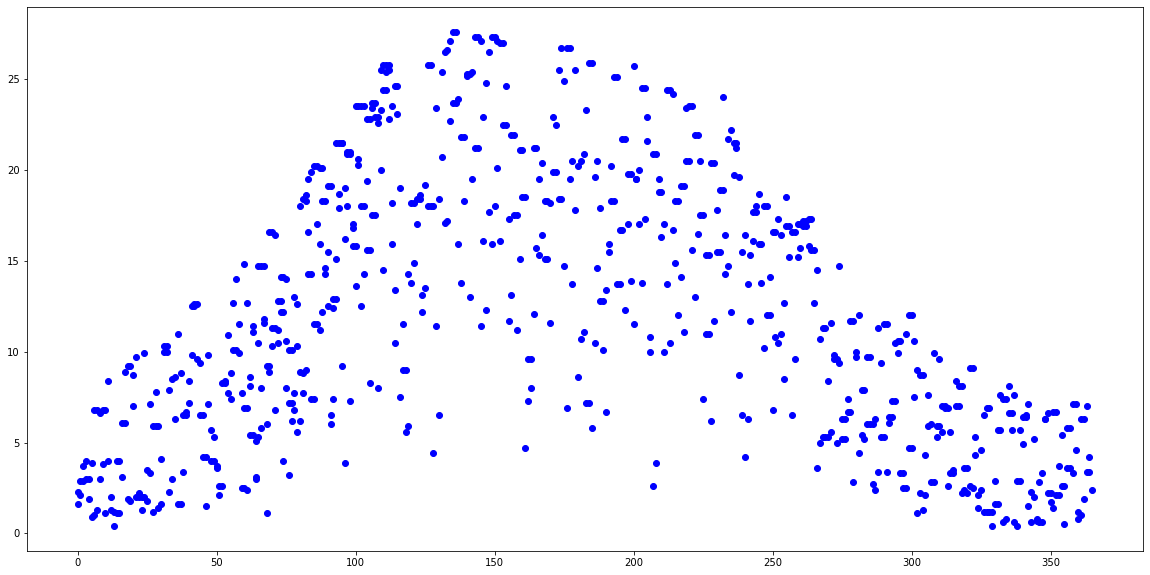

In [21]:
day_df['date'] = pd.to_datetime(day_df['date'])
day_df['Day'] = day_df['date'].apply(lambda x: (x.to_pydatetime().date() - datetime(x.to_pydatetime().year, 1,1 ).date()))
day_df['Day'] = day_df['Day'].dt.days
day_df = day_df.sort_values(by=['Day'], ignore_index=True)

plt.figure(figsize=(20,10))
plt.scatter(day_df['Day'], day_df['total_solar'], marker='o',color = 'blue')

## Assessing Correlation Between Forecast Data, Solar Production and Energy Consumption

It is useful to determine if there are any underlying correlations in the data which maybe useful when deciding what type of model to implement. 

A nice visual way is to plot a pair plot of the data as shown below. 

A more quantitative method to evaluate the correlation is to calculate the correlation matrix which is also shown below. 

It is clear to see that there are some trends in the data that link the weather conditions to solar production and energy consumption. 

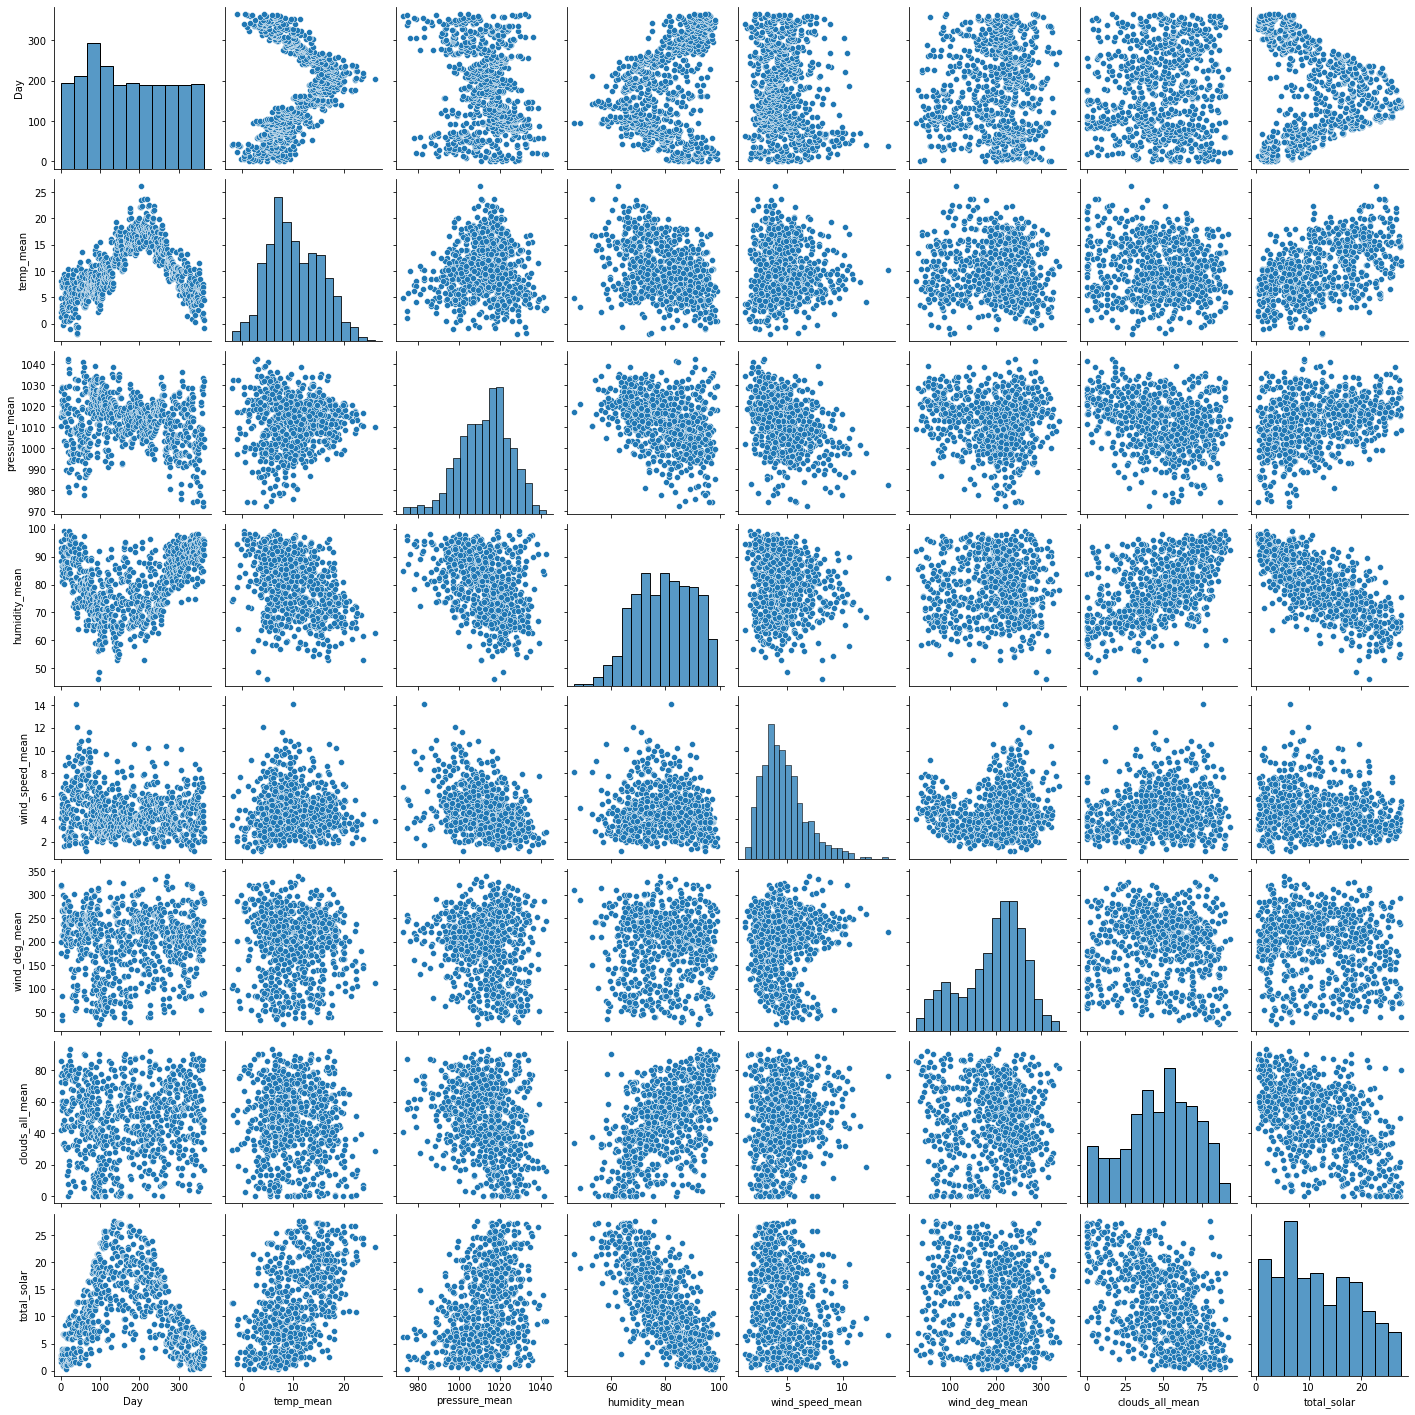

In [22]:
sns.pairplot(day_df[['Day', 'temp_mean', 'pressure_mean', 'humidity_mean', 'wind_speed_mean', 'wind_deg_mean', 'clouds_all_mean', 'total_solar']])

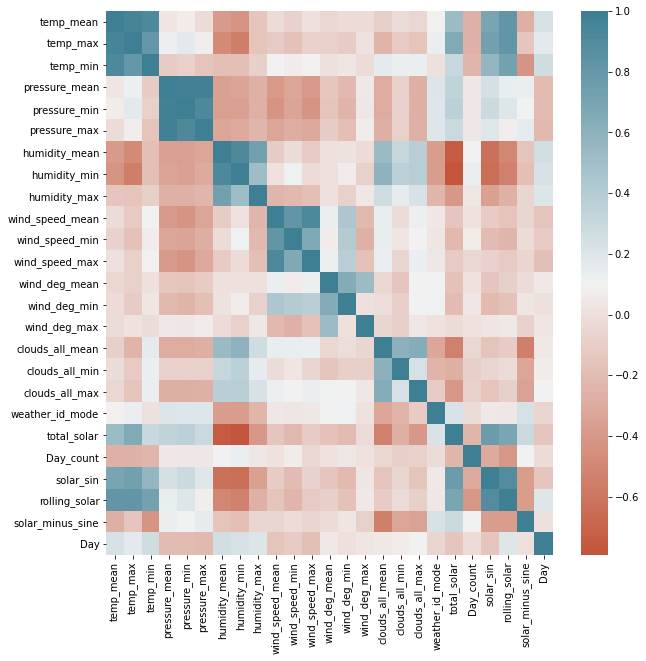

In [23]:
corrMatrix = day_df.corr()
plt.figure(figsize=(10,10))
heatmap_plot = sns.heatmap(corrMatrix, annot=False, cmap=sns.diverging_palette(20, 220, n=200))

## Producing Predictive Model for Energy Difference 

To test the the accuracy of any model implemented the data is split into a training set and a test set. The model can then be created using the training data set and trailed on the testing data set to determine when changes are made if they offer an improvement. Ideally, no information from the test data should be used to scale the training data or should be used to direct the training process of a machine learning model. Hence, we first split the data and then apply the scaling.

In [24]:
# Implement Test-Train Split 

inputs  = day_df[['Day', 'temp_mean', 'pressure_mean', 'humidity_mean', 'wind_speed_mean', 'wind_deg_mean', 'clouds_all_mean']].to_numpy()
output = day_df[['total_solar']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(inputs, output, test_size=0.25, random_state=42)

## Implementing polynomial regression and determining the most suitable order of polynomial to be used

Polynomial regressions are simple to implement and can provide an accurate result providing the right order of polynomial is used. Below a range from first order to sixth order polynomials are trained then tested for accuracy.

In [25]:
poly_order = np.arange(1,5)

r_sq_train = []
r_sq_test = []

for poly in poly_order:

    #print(poly)
    X_train_poly = PolynomialFeatures(degree=poly, include_bias=False).fit_transform(X_train)
    X_test_poly = PolynomialFeatures(degree=poly, include_bias=False).fit_transform(X_test)

    model = LinearRegression().fit(X_train_poly, y_train)

    y_pred = model.predict(X_test_poly)

    # r_sq_train[poly] = model.score(X_train_poly, y_train)
    # r_sq_test[poly] = model.score(X_test_poly, y_test)

    r_sq_train.append(model.score(X_train_poly, y_train))
    r_sq_test.append(model.score(X_test_poly, y_test))

Text(0, 0.5, 'score')

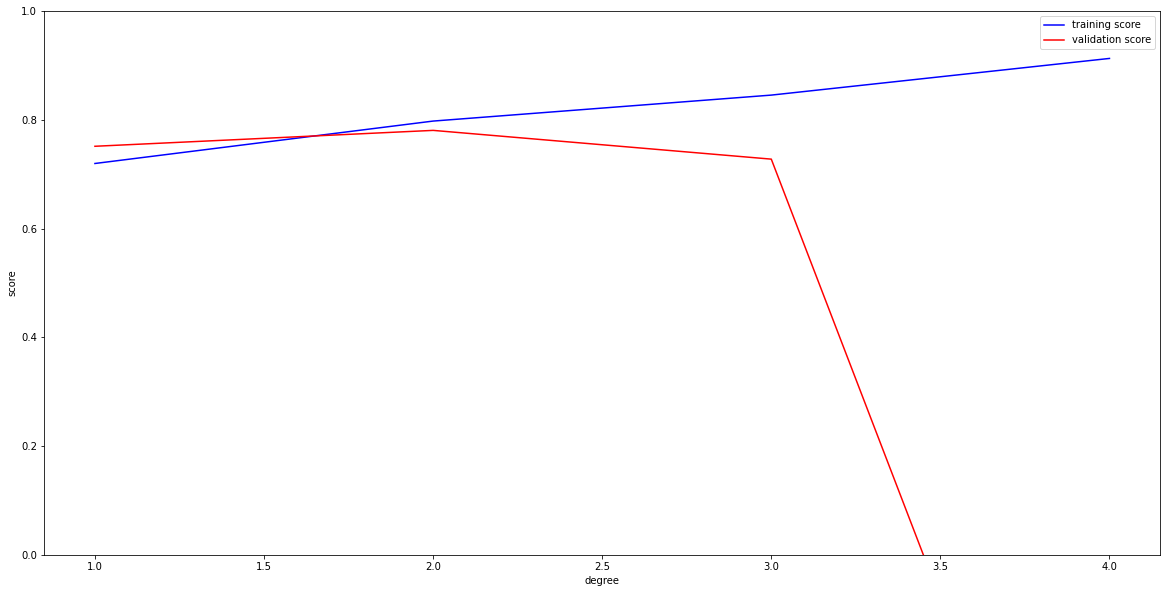

In [26]:
plt.figure(figsize=(20,10))
plt.plot(poly_order, r_sq_train, color='blue', label='training score')
plt.plot(poly_order, r_sq_test, color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')

From the plot above it can be seen that a third order polynomial gives the best result. 

Using this parameter we can analyse the accuracy of the model an the implications for use. 

In [27]:
# Implement polynomial regression 

poly_order = r_sq_test.index(max(r_sq_test)) + 1

X_train_poly = PolynomialFeatures(degree=poly_order, include_bias=False).fit_transform(X_train)
X_test_poly = PolynomialFeatures(degree=poly_order, include_bias=False).fit_transform(X_test)

model = LinearRegression().fit(X_train_poly, y_train)

y_pred = model.predict(X_test_poly)

r_sq = model.score(X_test_poly, y_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print('R Squared = ',r_sq)
print('RMSE = ', rmse)

R Squared =  0.7807563634913866
RMSE =  3.428197706482677


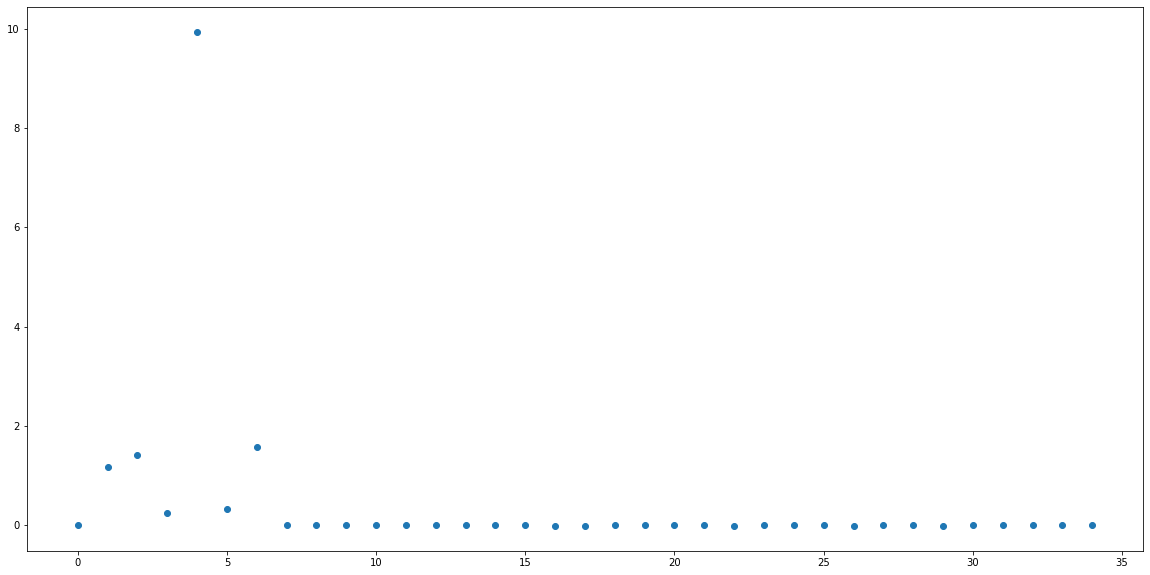

In [28]:
# Retrieve the regression coefficients
fit_coef = model.coef_

plt.figure(figsize=(20,10))
plt.scatter(range(0,len(fit_coef[0])),fit_coef)

(0.0, 365.0)

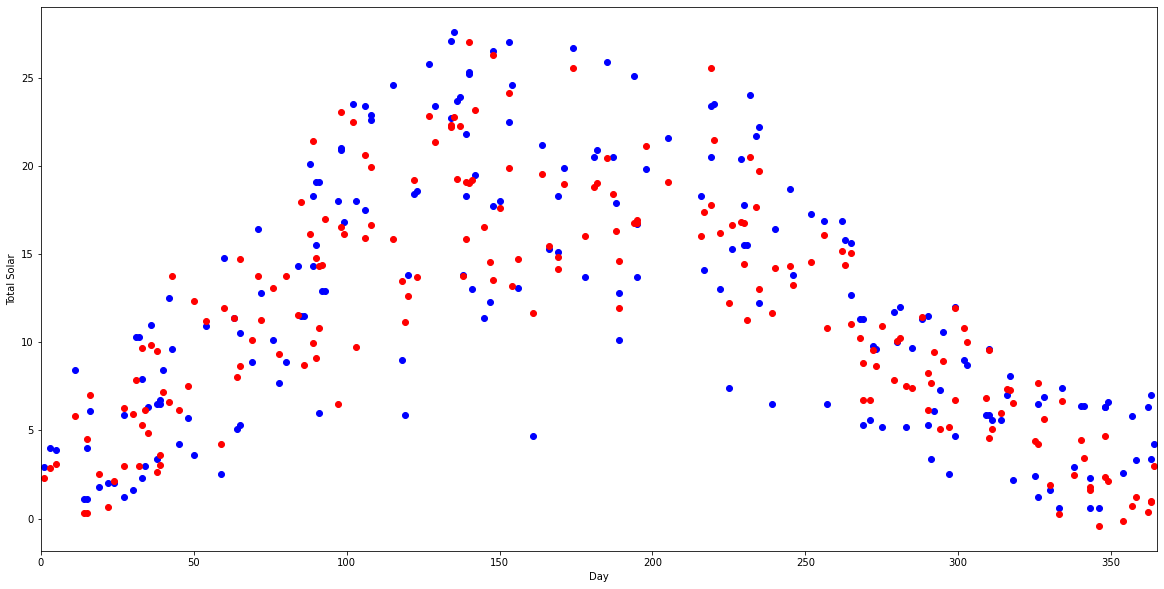

In [29]:
plt.figure(figsize=(20,10))
plt.scatter(X_test[:, 0], y_test, marker='o',color = 'blue')
plt.scatter(X_test[:, 0], y_pred, marker='o',color = 'red')
plt.xlabel('Day')
plt.ylabel('Total Solar')
plt.xlim([0, 365])

(0.0, 365.0)

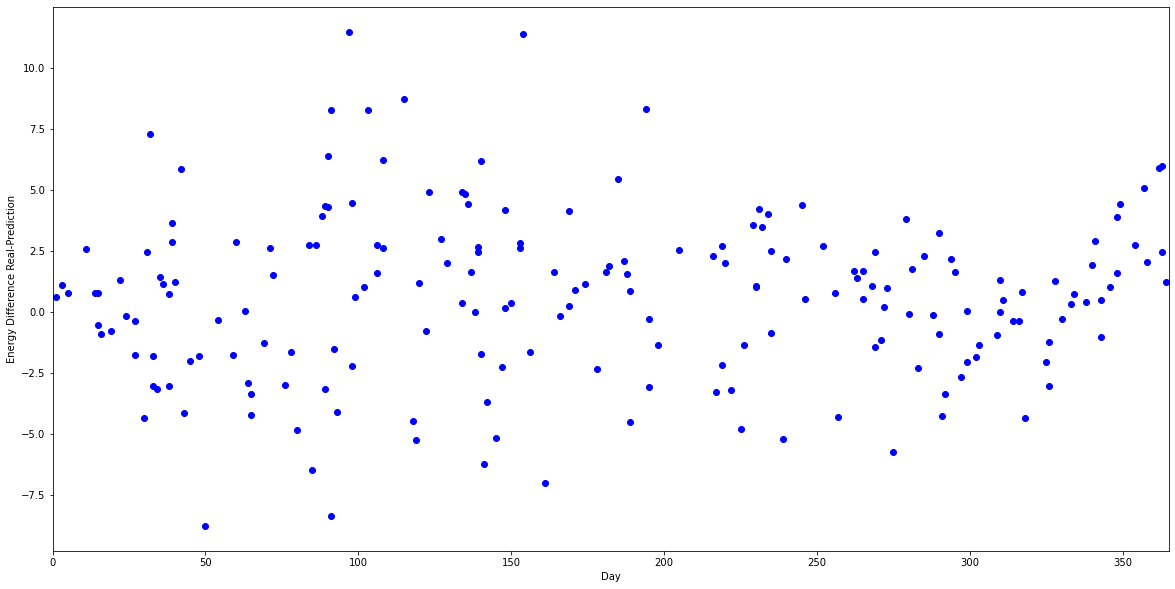

In [30]:
plt.figure(figsize=(20,10))
plt.scatter(X_test[:, 0], y_test - y_pred, marker='o',color = 'blue')
plt.xlabel('Day')
plt.ylabel('Energy Difference Real-Prediction')
plt.xlim([0, 365])

## Evaluation of Regression Model 

From this it is clear that there can be significant differences between the predicted energy difference and real value. This suggests that the model isn't particularly accurate for this application and other methods maybe more suitable.

## Reducing Resolution of Solar Energy Produced Per Day

In real terms for the application a 100% accurate estimation for the level of solar energy production for the day is not required. The data has been rounded down to the nearest integer so that in general the model should give an underestimate for the level of solar production for the day. 

In [32]:
day_df['solar_discrete'] = day_df.total_solar.apply(np.floor)

day_df.head()

,date,temp_mean,temp_max,temp_min,pressure_mean,pressure_min,pressure_max,humidity_mean,humidity_min,humidity_max,...,clouds_all_min,clouds_all_max,weather_id_mode,total_solar,Day_count,solar_sin,rolling_solar,solar_minus_sine,Day,solar_discrete
0,2020-01-01,4.867500,6.67,2.78,1027.125000,1023,1031,93.291667,86,100,...,75,90,721,1.6,376,1.167581,4.226667,0.432419,0,1.0
1,2021-01-01,2.284167,5.62,-2.78,1010.458333,1008,1014,95.708333,87,100,...,40,100,701,2.3,742,1.204620,4.260000,1.095380,0,2.0
2,2021-01-02,1.359167,5.00,-1.67,1015.500000,1014,1017,91.666667,80,100,...,0,75,801,2.9,743,1.244831,4.208333,1.655169,1,2.0
3,2020-01-02,8.192917,10.56,5.00,1014.916667,1009,1023,88.333333,76,100,...,75,90,803,2.1,377,1.204620,4.163333,0.895380,1,2.0
4,2021-01-03,3.609167,5.74,1.00,1020.916667,1019,1023,86.666667,80,93,...,40,75,803,2.9,744,1.288203,4.091667,1.611797,2,2.0


Text(0, 0.5, 'Solar Energy Production / kWH')

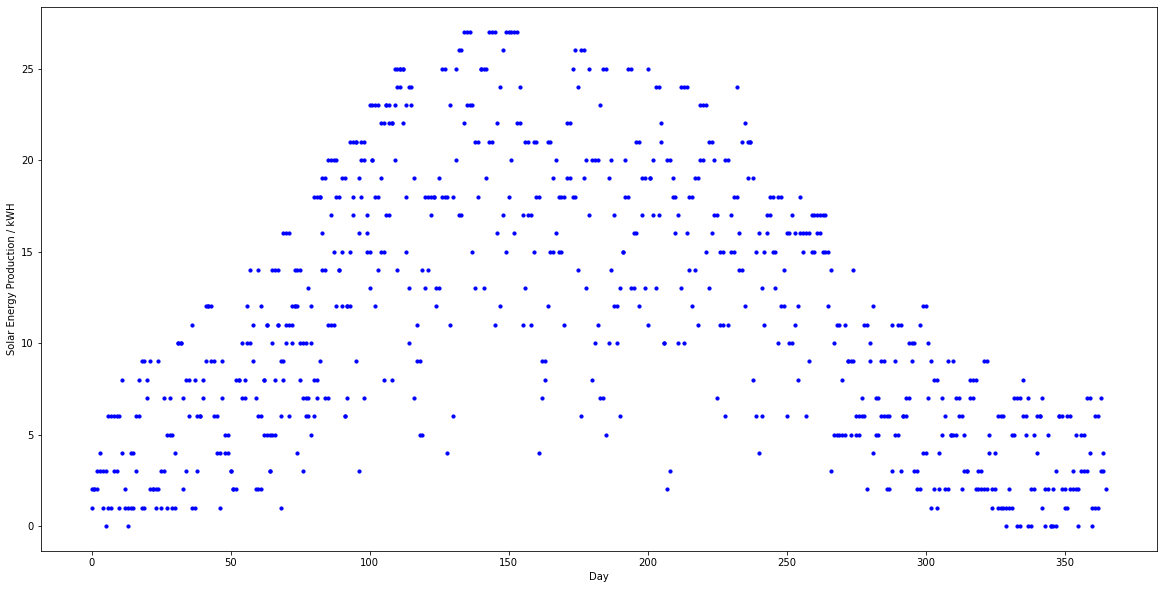

In [44]:
plt.figure(figsize=(20,10))
plt.scatter(day_df['Day'], day_df['solar_discrete'], marker='o',color = 'blue', s=10)

plt.xlabel('Day')
plt.ylabel('Solar Energy Production / kWH')

## Implement Test-Train Split 

In [34]:
inputs  = day_df[['Day', 'temp_mean', 'pressure_mean', 'humidity_mean', 'wind_speed_mean', 'wind_deg_mean', 'clouds_all_mean']].to_numpy()
output = day_df[['solar_discrete']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(inputs, output, test_size=0.25, random_state=42)

## Implementing Decision Tree Regressor

In [45]:
from sklearn.tree import DecisionTreeRegressor

accuracy = []

for i in range(1,20):

    tree_clf = DecisionTreeClassifier(max_depth=i)

    tree_clf.fit(X_train,y_train)

    y_pred = tree_clf.predict(X_test)

    accuracy.append(accuracy_score(y_test,y_pred))

max_accuracy = max(accuracy)
max_index = accuracy.index(max_accuracy) 

print('Max Accuracy  = ', max_accuracy)
print('Optimal Max depth = ', max_index + 1)

Max Accuracy  =  0.18846153846153846
Optimal Max depth =  9


## Implementing Decision Tree Classifier 

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

accuracy = []

for i in range(1,20):

    tree_clf = DecisionTreeClassifier(max_depth=i)

    tree_clf.fit(X_train,y_train)

    y_pred = tree_clf.predict(X_test)

    accuracy.append(accuracy_score(y_test,y_pred))

max_accuracy = max(accuracy)
max_index = accuracy.index(max_accuracy) 

print('Max Accuracy  = ', max_accuracy)
print('Optimal Max depth = ', max_index + 1)


Max Accuracy  =  0.17258883248730963
Optimal Max depth =  14


## Implementing Cross Validation rather than test-train split

In [ ]:
from sklearn.model_selection import cross_val_score

# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')




In [37]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))


The depth-4 tree achieves the best mean cross-validation accuracy 13.5796 +/- 2.61294% on training dataset


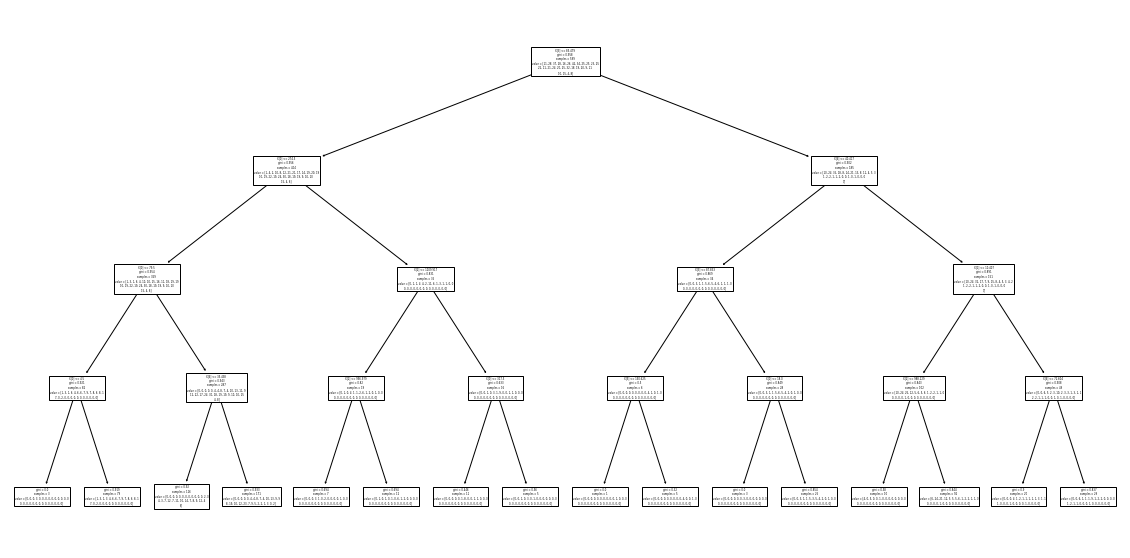

In [38]:
from sklearn.tree import plot_tree

tree_clf = DecisionTreeClassifier(max_depth=(sm_best_tree_depth))

tree_clf.fit(X_train,y_train)

y_pred = tree_clf.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)

#print(accuracy)
plt.figure(figsize=(20,10))
plot_tree(tree_clf.fit(X_train, y_train));

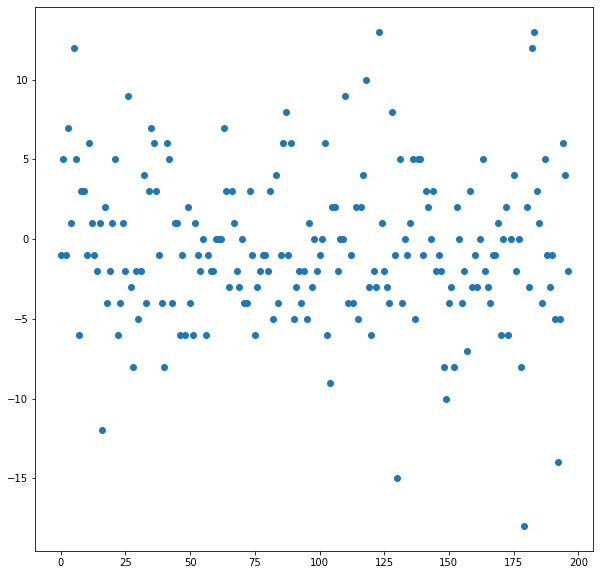

In [39]:
error = y_pred - y_test.flatten()

plt.figure(figsize=(10,10))
plt.scatter(range(0,len(error)),error)

In [40]:
print('Percentage of incorrect predictions  = ', np.count_nonzero(error)/len(error) * 100)
print('Number of values which are underestimated = ', np.sum(np.array(error) < 0, axis=0), 'Out of ', len(error))
print('Percentage of underestimated predictions  = ', round((np.sum(np.array(error) < 0, axis=0)/len(error) * 100),2))

Percentage of incorrect predictions  =  91.87817258883248
Number of values which are underestimated =  111 Out of  197
Percentage of underestimated predictions  =  56.35


# Using XGBClassifier



In [41]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

inputs  = day_df[['Day', 'temp_mean', 'pressure_mean', 'humidity_mean', 'wind_speed_mean', 'wind_deg_mean', 'clouds_all_mean']].to_numpy()
output = day_df[['solar_discrete']].to_numpy().ravel()

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(inputs, output, test_size=test_size, random_state=seed)
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


C:\Users\chris\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:16:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 17.69%


# Hyperparameter Tuning 

### todo: add hyper parameter tuning to XGBoost  